# What is LangGraph and Can It Help You Build LLM Agents?

In this post we are going to answer both those questions. Let's start with the first one, and the second will naturally unfold as we go on.

### What is LangGraph?

I'll try to be a little less technical than others who have discussed this. We need a light read sometimes, don't we? Sooo… **LangGraph!** Simply put, LangGraph is a tool that helps you build smarter applications using large language models (LLMs). Think of it as an extension to another tool called **LangChain**.

*"What's that?"* you might ask. Well, **LangChain** is a tool that allows you to create sequences of actions (like a list of steps). **LangGraph**, on the other hand, lets you add loops to these sequences. This means you can ask your language model to repeatedly decide what to do next, making your application more interactive and capable of handling more complex tasks.

Still a bit fuzzy? Let me break it down further.

Imagine **LangChain** as a beginner cook following a simple recipe. The newbie goes step-by-step, adding ingredients in a specific order until the dish is complete. They can't go back and change anything once they've moved to the next step.

**LangGraph**, on the other hand, is like a master chef who can taste the dish at each step, adjust the seasoning, go back to add more ingredients, and tweak the cooking process as needed. The chef can keep refining the dish, going back and forth between steps, until it's perfect. This flexibility allows the chef to adapt and improve the dish continuously, just like **LangGraph** enables continuous decision-making and improvement in building LLM agents.

In essence, **LangGraph** is a step up from **LangChain**. While **LangChain** does the job, **LangGraph** will take your projects to a whole new level. Honestly? It's the tool you didn't know you needed until you see what it can do.

Now, let's dive into a simple example that will clear things up while taking us deeper into **LangGraph**. We'll create a simple chatbot that will respond directly to user messages. Although simple, it will serve the purpose to illustrate the core concepts of building with LangGraph.


## Setup

First we need to install the packages required.

In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith

# Used for this tutorial; not a requirement for LangGraph
%pip install -U langchain_openai

Next, let's set the API key for OpenAI.

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:········


Also, let's set up our [LangSmith](https://www.langchain.com/langsmith) key as it makes a lot easier to see what's going on under the hood (optional, but encouraged).

In [4]:
os.environ["LANGSMITH_API_KEY"] = getpass.getpass("LangSmith API Key:")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

LangSmith API Key:········


## Step 1: Define the State

In this step, we define the state structure for our graph by setting up the `StateGraph`. This structure holds data that can change as the process runs.

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


class State(TypedDict):
    # The `add_messages` function within the annotation defines
    # *how* updates should be merged into the state.
    messages: Annotated[list, add_messages]

For this example, the state we will track is just a list of messages. Each node will add messages to that list.

## Step 2: Create the Graph

Next, we create a new instance of `StateGraph` with our `State` structure.

In [6]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)

## Step 3: Define the Nodes

In this step, we define one agent called `chatbot`. This agent is a function that takes the current `State` as input and returns an updated list of messages. The function uses a Language Model (LLM) to generate responses based on the input messages.

In [7]:
from langchain_openai import ChatOpenAI


# Import the necessary chatbot module
llm = ChatOpenAI(openai_api_key=os.environ["OPENAI_API_KEY"],model="gpt-3.5-turbo")

# Define the chatbot function incorporating the language model
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

Next, we add nodes using the `graph.add_node(name, value)` syntax. Nodes represent units of work, which are typically regular Python functions or [runnables](https://python.langchain.com/v0.1/docs/expression_language/).

In [8]:
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever the node is used.
# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

In this case, we've added a node named "chatbot" that will be responsible for handling the chatbot's interactions. The `add_messages` function in our `State` will append the LLM's response messages to the existing messages in the state.

## Step 4: Configure Entry and Exit Points

Next, we need to set the **entry point**. This tells our graph where to start its work each time we run it.

In [9]:
graph_builder.set_entry_point("chatbot")

We also need to set a **finish point**. This instructs the graph, "any time this node is run, you can exit".

In [10]:
graph_builder.set_finish_point("chatbot")

## Step 5: Compile

Finally, we'll compile our graph. This creates a `CompiledGraph` that we can use to invoke our state.

In [11]:
graph = graph_builder.compile()

## Step 6: Visualize and Run the Chatbot

We can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_mermaid_png`. The draw methods each require additional dependencies.

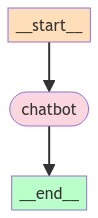

In [12]:
from IPython.display import Image, display

# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

### Now let's run the chatbot!

The chatbot will continue to run in a loop until you type "quit", "exit", or "q".

In [13]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User: What's LangGraph all about?
Assistant: LangGraph is a language learning platform that uses graph-based algorithms to help users learn new languages more efficiently. It uses a variety of interactive exercises and games to help users improve their vocabulary, grammar, and pronunciation skills. The platform also provides personalized feedback and progress tracking to help users stay motivated and on track with their language learning goals.
User: q
Goodbye!


As seen above, the chatbot's responses might not always be accurate due to the limitations of the Language Model (LLM) on specific topics. To improve the chatbot's accuracy and provide more relevant responses, we can integrate additional tools, which we will explore next.

### Visualizing the Chatbot's Execution

Also, check what we got from LangSmith when running the current chatbot:

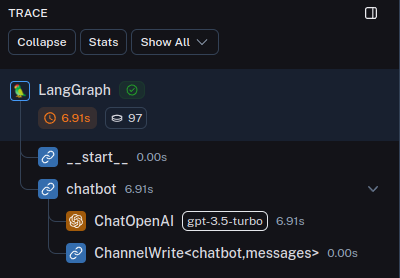

Not much flavor, huh, chef? Let's sprinkle in some MSG to give it that extra kick!

# Enhance the Chatbot with Tools

Hope you are ready because now we will improve our chatbot by integrating it with a web search tool. This will allow the chatbot to fetch and use relevant information from the web to provide more accurate and helpful responses.

## Step 1: Setting Up the Web Search Tool

Before we start, ensure you have the necessary packages installed and API keys set up. We'll be using the [Tavily Search Engine](https://python.langchain.com/v0.1/docs/integrations/tools/tavily_search/). **It's super easy to register and they offer a free tier.**

In [14]:
# Prompting for the Tavily API Key and storing it in an environment variable.
os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key:")

Tavily API Key:········


Let's create and test the tool that interacts with the Tavily Search API to retrieve search results in JSON format.

In [15]:
from langchain_community.tools.tavily_search import TavilySearchResults

# Initializing the search tool with a maximum of 2 results per query
tool = TavilySearchResults(max_results=2)

# Storing the tool in a list, which can be expanded with additional tools in the future
tools = [tool]

# Invoking the tool with a query to see the type of results it returns
tool.invoke("What's LangGraph all about?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': "Step 1: Define the Graph State. First, we define the state structure for our graph. In this example, our state includes the user's question, the classification of the question, and a response ..."},
 {'url': 'https://medium.com/@bhavikjikadara/langgraph-a-comprehensive-guide-for-beginners-ef17d3dd5383',
  'content': 'LangGraph is a versatile tool for building complex, stateful applications with LLMs. By understanding its core concepts and working through simple examples, beginners can start to leverage its ...'}]

The output will be page summaries that our chatbot can use to answer questions.

## Step 2: Defining the Graph

The following steps are similar to our initial example, with the addition of binding tools to our Language Model (LLM). This allows the LLM to use the Tavily Search API to fetch information.

In [16]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Import the necessary chatbot module and bind tools to enhance it
llm = ChatOpenAI(openai_api_key=os.environ["OPENAI_API_KEY"], model="gpt-3.5-turbo")
llm_with_tools = llm.bind_tools(tools)


# Define the chatbot function incorporating the enhanced language model
def chatbot_with_tools(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Add the enhanced chatbot as a node to the graph
graph_builder.add_node("chatbot_with_tools", chatbot_with_tools)

By integrating the ***Tavily Search Engine***, your chatbot can now fetch relevant information from the web. This means it will provide more accurate and helpful responses to user questions, enhancing the overall user experience with up-to-date online resources.

## Step 3: Add a tool node to the graph for conditional routing

To make our chatbot even more powerful, we will add a tool node to manage tool requests and utilize conditional edges to regulate the flow between tool usage and the main chatbot logic. We will use LangGraph's prebuilt `ToolNode` and `tools_condition`, which simplifies our setup and avoids the need to build these components from scratch. This is particularly useful for beginners.

In [17]:
from langgraph.prebuilt import ToolNode, tools_condition

# Add a node to handle tool usage
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)


# Add conditional edges to return to the chatbot after tool usage
graph_builder.add_conditional_edges(
    "chatbot_with_tools",
    tools_condition,
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot_with_tools")

# Set the entry point to the enhanced chatbot node
graph_builder.set_entry_point("chatbot_with_tools")

# Compile the graph
graph = graph_builder.compile()

See, with prebuilt components like `ToolNode` and `tools_condition`, setting up the graph becomes a breeze, letting us dive straight into crafting our chatbot. These handy tools take care of typical patterns and workflows, smoothing the path for newcomers. They're like having a ready-made spice mix, making life easier as you navigate through LangGraph.

## Step 4: Visualize and Run the Graph

You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_mermaid_png`.

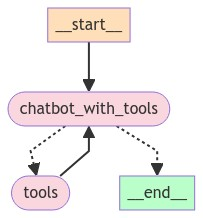

In [18]:
from IPython.display import Image, display

# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

##### NOW WE ARE COOKING!

### Let's run the new and improved chatbot!

The chatbot will continue to run in a loop until you type "quit", "exit", or "q".

In [19]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

User: What's LangGraph all about?
Assistant: 
Assistant: [{"url": "https://blog.langchain.dev/langgraph-multi-agent-workflows/", "content": "As a part of the launch, we highlighted two simple runtimes: one that is the equivalent of the AgentExecutor in langchain, and a second that was a version of that aimed at message passing and chat models.\n It's important to note that these three examples are only a few of the possible examples we could highlight - there are almost assuredly other examples out there and we look forward to seeing what the community comes up with!\n LangGraph: Multi-Agent Workflows\nLinks\nLast week we highlighted LangGraph - a new package (available in both Python and JS) to better enable creation of LLM workflows containing cycles, which are a critical component of most agent runtimes. \"\nAnother key difference between Autogen and LangGraph is that LangGraph is fully integrated into the LangChain ecosystem, meaning you take fully advantage of all the LangChain in

Awesome! By adding a web search tool into our chatbot loop, we've taken our responses from good to waaaaay better.

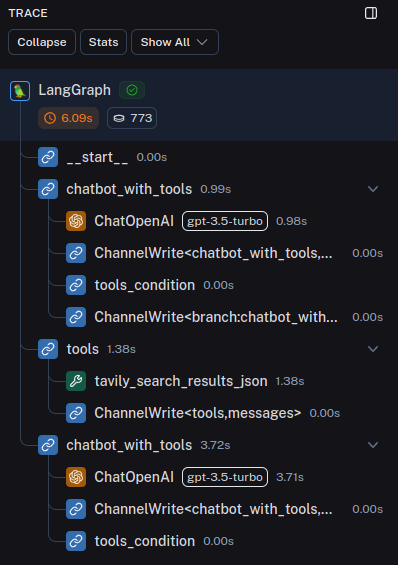

Wrap-up: With just a simple loop, we've spiced up our chatbot by fetching updated information whenever necessary. LangGraph enables fine-tuning, making your applications dynamic and responsive.

Thanks for joining me on this short tutorial! Putting it together taught me a lot, and I hope you found it as fascinating as I did. As you delve into your own projects, remember to give LangGraph a try — it's packed with some seriously cool features!

Stay tuned for future posts where we'll explore more advanced topics and customizations with LangGraph!

#### Happy coding!